# Scenario
**Chicago Airbnb**

You and a group of friends are
considering purchasing a property in
Chicago that you can use as an
investment. You have heard from other
people that they have made a lot of
money by renting out either a room or
an entire unit (apartment or house). Your
friends ask you to analyze data so that
they can understand how much you
would charge per night based on the
type of dwelling you were to purchase.

Now that the data has been prepared, I will make the necessary transformations to the data so that it can be used in a machine learning model. Then I will train a model to predict the 'availability_365'.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import joblib
import numpy as np
import pandas as pd
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sqlalchemy import create_engine
from tqdm import tqdm
tqdm.pandas()

import credentials

# Loading cleaned data

In [169]:
db_con = create_engine(credentials.DB_URL)

train_df = pd.read_sql('SELECT * FROM cleaned.train_listings', db_con)
val_df = pd.read_sql('SELECT * FROM cleaned.val_listings', db_con)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5012 entries, 0 to 5011
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood                 5012 non-null   object 
 1   latitude                      5012 non-null   float64
 2   longitude                     5012 non-null   float64
 3   room_type                     5012 non-null   object 
 4   price                         5012 non-null   int64  
 5   log_days_since_last_review    5012 non-null   float64
 6   log_reviews_per_month         5012 non-null   float64
 7   log_number_of_reviews         5012 non-null   float64
 8   log_price                     5012 non-null   float64
 9   log_minimum_nights            5012 non-null   float64
 10  log_host_listings_count       5012 non-null   float64
 11  log_nights_booked             5012 non-null   float64
 12  minimum_booking_price         5012 non-null   float64
 13  hos

<Axes: >

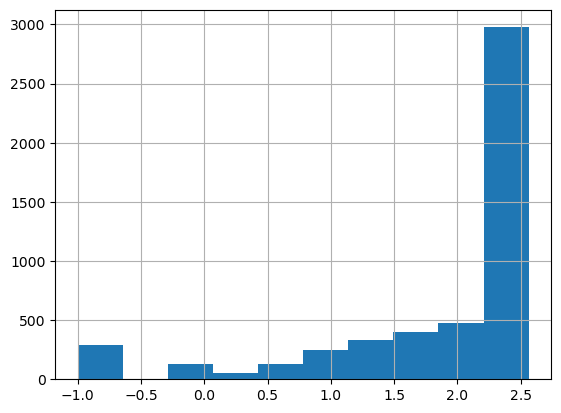

In [170]:
train_df.log_nights_booked.hist()

# Preprocessing pipeline

Here's the deal: the goal is to optimize the income from listings based on changing the price input into the model. Scaling the features adds a whole other layer of complexity to that optimization so to avoid that, I will only use models that are scale-invariant and not use scaling in the preprocessing pipeline. 

What I will do though is try OneHotEncoding vs. OrdinalEncoding for the categorical features and see which one performs better. I know OrdinalEncoding injects some bias, but I want to try, because otherwise features like neighbourhood will be split too far and not be useful enough for my feature selection process.

In [171]:
# Split data into X and y
X_train, y_train = train_df.drop(columns='log_nights_booked'), train_df['log_nights_booked']
X_val, y_val = val_df.drop(columns='log_nights_booked'), val_df['log_nights_booked']

# Set objects to category
X_train['neighbourhood'] = X_train['neighbourhood'].astype('category')
X_val['neighbourhood'] = X_val['neighbourhood'].astype('category')
X_train['room_type'] = X_train['room_type'].astype('category')
X_val['room_type'] = X_val['room_type'].astype('category')

In [172]:
ohe_processor = make_column_transformer(
    (OneHotEncoder(handle_unknown='infrequent_if_exist'), make_column_selector(dtype_include='category')),
    remainder='passthrough'
)
ord_processor = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), make_column_selector(dtype_include='category')),
    remainder='passthrough'
)
pd.DataFrame(ord_processor.fit_transform(X_train), columns=ord_processor.get_feature_names_out())

,ordinalencoder__neighbourhood,ordinalencoder__room_type,remainder__latitude,remainder__longitude,remainder__price,remainder__log_days_since_last_review,remainder__log_reviews_per_month,remainder__log_number_of_reviews,remainder__log_price,remainder__log_minimum_nights,remainder__log_host_listings_count,remainder__minimum_booking_price,remainder__host_listings_minimum_nights,remainder__price^2,remainder__price^3,remainder__price^4
0,29.0,2.0,41.64736,-87.61679,69.0,-1.000000,-1.000000,-1.000000,1.838849,0.000000,0.00000,0.000000,0.000000,4761.0,328509.0,2.266712e+07
1,29.0,2.0,41.65208,-87.61030,22.0,-1.000000,-1.000000,-1.000000,1.342423,1.477121,0.00000,1.982921,0.000000,484.0,10648.0,2.342560e+05
2,29.0,2.0,41.65388,-87.61021,22.0,-1.000000,-1.000000,-1.000000,1.342423,1.477121,0.00000,1.982921,0.000000,484.0,10648.0,2.342560e+05
3,29.0,0.0,41.65578,-87.53790,200.0,2.274389,-0.494850,0.612784,2.301030,1.778151,0.60206,4.091579,1.070554,40000.0,8000000.0,1.600000e+09
4,29.0,0.0,41.65977,-87.65236,90.0,-1.000000,-1.000000,-1.000000,1.954243,0.000000,0.60206,0.000000,0.000000,8100.0,729000.0,6.561000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,23.0,2.0,42.02087,-87.67286,68.0,2.442637,-0.568636,0.041393,1.832509,0.698970,0.30103,1.280869,0.210411,4624.0,314432.0,2.138138e+07
5008,23.0,2.0,42.02105,-87.67300,45.0,2.117603,0.250420,1.903633,1.653213,0.477121,0.30103,0.788783,0.143628,2025.0,91125.0,4.100625e+06
5009,23.0,0.0,42.02119,-87.66411,140.0,2.029789,0.367356,1.149219,2.146128,0.477121,0.00000,1.023963,0.000000,19600.0,2744000.0,3.841600e+08
5010,23.0,2.0,42.02139,-87.67363,60.0,2.542950,-0.040959,1.725095,1.778151,0.477121,0.30103,0.848394,0.143628,3600.0,216000.0,1.296000e+07


In [173]:
pd.DataFrame(ohe_processor.fit_transform(X_train), columns=ohe_processor.get_feature_names_out())

,onehotencoder__neighbourhood_Albany Park,onehotencoder__neighbourhood_Armour Square,onehotencoder__neighbourhood_Austin,onehotencoder__neighbourhood_Avondale,onehotencoder__neighbourhood_Bridgeport,onehotencoder__neighbourhood_Douglas,onehotencoder__neighbourhood_East Garfield Park,onehotencoder__neighbourhood_Edgewater,onehotencoder__neighbourhood_Grand Boulevard,onehotencoder__neighbourhood_Humboldt Park,...,remainder__log_reviews_per_month,remainder__log_number_of_reviews,remainder__log_price,remainder__log_minimum_nights,remainder__log_host_listings_count,remainder__minimum_booking_price,remainder__host_listings_minimum_nights,remainder__price^2,remainder__price^3,remainder__price^4
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,1.838849,0.000000,0.00000,0.000000,0.000000,4761.0,328509.0,2.266712e+07
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,1.342423,1.477121,0.00000,1.982921,0.000000,484.0,10648.0,2.342560e+05
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,1.342423,1.477121,0.00000,1.982921,0.000000,484.0,10648.0,2.342560e+05
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.494850,0.612784,2.301030,1.778151,0.60206,4.091579,1.070554,40000.0,8000000.0,1.600000e+09
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,1.954243,0.000000,0.60206,0.000000,0.000000,8100.0,729000.0,6.561000e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.568636,0.041393,1.832509,0.698970,0.30103,1.280869,0.210411,4624.0,314432.0,2.138138e+07
5008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.250420,1.903633,1.653213,0.477121,0.30103,0.788783,0.143628,2025.0,91125.0,4.100625e+06
5009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.367356,1.149219,2.146128,0.477121,0.00000,1.023963,0.000000,19600.0,2744000.0,3.841600e+08
5010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.040959,1.725095,1.778151,0.477121,0.30103,0.848394,0.143628,3600.0,216000.0,1.296000e+07


Looks like it works.

# Ordinal vs OneHot

In [162]:
rfr = RandomForestRegressor(random_state=42)
ohe_pipe = make_pipeline(ohe_processor, rfr)
ord_pipe = make_pipeline(ord_processor, rfr)
ohe_scores = cross_val_score(ohe_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
ord_scores = cross_val_score(ord_pipe, X_train, y_train, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
print(f"OHE: {ohe_scores.mean()}")
print(f"ORD: {ord_scores.mean()}")

OHE: -0.842453253108218
ORD: -0.9378124911584459


Well, it was worth a try. OneHotEncoding is what I will use for the categorical features.

# Random Forest Feature Importance Feature Selection

In [163]:
X_train['random'] = np.random.randn(X_train.shape[0])
ohe_pipe.fit(X_train, y_train)
feat_imp = pd.Series(rfr.feature_importances_, index=ohe_pipe.named_steps['columntransformer'].get_feature_names_out())
feat_imp = feat_imp.sort_values(ascending=False)
feat_imp.head(15)

KeyboardInterrupt: 

Looks like I can drop quite a few features and I won't even need the OneHotEncoder. I will drop everything that is less important than the 'random' feature besides price. It is what I am trying to optimize and if you add up all the importances of the price features, they are more important than the 'random' feature.

In [ ]:
def select_features(df):
    return df.drop(columns=[col for col in df.columns if col not in ['log_days_since_last_review', 'log_price', 'price', 'price^2', 'price^3', 'price^4', 'longitude', 'latitude']])

In [ ]:
X_train, X_val = select_features(X_train), select_features(X_val)
X_train

,latitude,longitude,price,log_days_since_last_review,log_price,price^2,price^3,price^4
0,41.64736,-87.61679,69,-1.000000,1.838849,4761,328509,22667121
1,41.65208,-87.61030,22,-1.000000,1.342423,484,10648,234256
2,41.65388,-87.61021,22,-1.000000,1.342423,484,10648,234256
3,41.65578,-87.53790,200,2.274389,2.301030,40000,8000000,1600000000
4,41.65977,-87.65236,90,-1.000000,1.954243,8100,729000,65610000
...,...,...,...,...,...,...,...,...
4721,42.02087,-87.67286,68,2.442637,1.832509,4624,314432,21381376
4722,42.02105,-87.67300,45,2.117603,1.653213,2025,91125,4100625
4723,42.02119,-87.66411,140,2.029789,2.146128,19600,2744000,384160000
4724,42.02139,-87.67363,60,2.542950,1.778151,3600,216000,12960000


# Model selection

Again, only scale-invariant models. Mainly tree-based models and linear regression with no regularization.

In [174]:
models = [
    # Linear Models
    ('Linear Regression', LinearRegression()),
    
    # Tree Models
    ('Decision Tree', DecisionTreeRegressor(random_state=42)),
    ('AdaBoost', AdaBoostRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
]

model_names = []
MSEs = []
MAEs = []
r2_scores = []

for name, model in models:
    print(f'Running {name}')
    pipe = make_pipeline(ohe_processor, model)
    preds = cross_val_predict(pipe, X_train, y_train, cv=3, n_jobs=-1)
    
    # Append results to lists
    model_names.append(name)
    MSEs.append(mean_squared_error(y_train, preds))
    MAEs.append(mean_absolute_error(y_train, preds))
    r2_scores.append(r2_score(y_train, preds))

# Create DataFrame
results_df = pd.DataFrame({
    'Model': model_names,
    'MSE': MSEs,
    'MAE': MAEs,
    'R2': r2_scores
})
results_df.sort_values('R2', ascending=False)

Running Linear Regression
Running Decision Tree
Running AdaBoost
Running Random Forest
Running Gradient Boosting


,Model,MSE,MAE,R2
4,Gradient Boosting,0.800773,0.658217,0.112002
3,Random Forest,0.842436,0.718246,0.065801
0,Linear Regression,0.897769,0.700803,0.004440
2,AdaBoost,0.925720,0.819579,-0.026556
1,Decision Tree,1.710925,0.893376,-0.897289


Random Forest Regressor is the best model for this dataset. Now I will tune the hyperparameters.

# Gradient boosting hyperparameter tuning

Random forests are scale invariant so I wont include the StandardScaler in the pipeline and I'll unscale the target.

In [190]:
gbr = GradientBoostingRegressor(random_state=42)
pipe = make_pipeline(ohe_processor, gbr)
param_grid = {
    'gradientboostingregressor__learning_rate': np.logspace(-3, 0, 4),
    'gradientboostingregressor__subsample': np.linspace(0.5, 1, 4),
    'gradientboostingregressor__max_depth': range(3, 13, 3),
    'gradientboostingregressor__max_features': ['sqrt', None],
}

gbr_search = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=1)
gbr_search.fit(X_train, y_train)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7c54b9a4d810>)])),
                                       ('gradientboostingregressor',
                                        GradientBoostingRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'gradientboostingregressor__learning_rate': array([0.001, 0.01 , 0.1  , 1.   ]),
                         'gradientboostingregressor__max_depth': range(3, 13, 3),
                         'gradientboostingregressor__max_features': ['sqrt',
                                                                     None],
                         'gradientboostingregressor__subsample': array([0.5       , 0.66666667, 0.83333333, 1.        ])},
             scoring='r2', verbose=1)

In [191]:
gbr_search.best_params_, gbr_search.best_score_

({'gradientboostingregressor__learning_rate': np.float64(0.01),
  'gradientboostingregressor__max_depth': 9,
  'gradientboostingregressor__max_features': 'sqrt',
  'gradientboostingregressor__subsample': np.float64(0.8333333333333333)},
 np.float64(0.1400946856140073))

The best score is slightly better than the base hyperparameters used when doing model selection. 

# Testing on the validation set

In [192]:
r2_score(y_val, gbr_search.best_estimator_.predict(X_val))

0.2259244206603439

Using the full training set gave a slightly better score yet for the validation set.

# Optimizing income

The income of a listing is the price * (365 - availability_365). To optimize the income, I will use the model to predict the availability_365 and then calculate the income for various prices.

In [194]:
pipe = make_pipeline(ohe_processor, GradientBoostingRegressor(random_state=42, n_estimators=300))
pipe.set_params(**gbr_search.best_params_)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c54b9a4d810>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=np.float64(0.01),
                                           max_depth=9, max_features='sqrt',
                                           n_estimators=300, random_state=42,
                                           subsample=np.float64(0.8333333333333333)))])

In [195]:
# Function to add best price, bookings, and revenue to a DataFrame
def optimize_income(x):
    x = x.copy()
    # Log price is standardized, so this is + or - 1.5 standard deviations
    price_min = 20
    price_max = 1000
    best_revenue = 0
    best_price = 0
    best_bookings = 0
    for price in np.linspace(price_min, price_max, 100):
        x['price'] = price
        x['log_price'] = np.log(price)
        x['price^2'] = price ** 2
        x['price^3'] = price ** 3
        x['price^4'] = price ** 4
        predicted_bookings = 10 ** pipe.predict(x.to_frame().T)[0]
        projected_revenue = price * predicted_bookings
        if projected_revenue > best_revenue:
            best_revenue = projected_revenue
            best_price = price
            best_bookings = predicted_bookings
    return best_revenue, best_price, best_bookings

In [196]:
X_val_opt  = X_val.sample(100).copy()
X_val_opt['best_revenue'], X_val_opt['best_price'], X_val_opt['best_bookings'] = zip(*X_val_opt.progress_apply(optimize_income, axis=1))
X_val_opt

Pandas Apply:   0%|          | 0/100 [00:00<?, ?it/s]

,neighbourhood,latitude,longitude,room_type,price,log_days_since_last_review,log_reviews_per_month,log_number_of_reviews,log_price,log_minimum_nights,log_host_listings_count,minimum_booking_price,host_listings_minimum_nights,price^2,price^3,price^4,best_revenue,best_price,best_bookings
755,Lincoln Park,41.91114,-87.64861,Entire home/apt,200,2.487280,0.592177,2.344589,2.301030,0.301030,0.000000,0.692679,0.000000,40000,8000000,1600000000,57347.717708,821.818182,69.781515
134,Lake View,41.94594,-87.65431,Hotel room,30,2.471438,0.656098,2.492900,1.477121,0.000000,0.698970,0.000000,0.000000,900,27000,810000,41792.352908,841.616162,49.657260
56,West Town,41.90100,-87.68221,Entire home/apt,1250,2.204391,-0.207608,0.041393,3.096910,0.301030,0.301030,0.932263,0.090619,1562500,1953125000,2441406250000,44520.221254,940.606061,47.331421
98,Woodlawn,41.77600,-87.60400,Entire home/apt,91,2.143327,0.432969,1.281033,1.959041,0.301030,0.000000,0.589730,0.000000,8281,753571,68574961,40818.762247,841.616162,48.500450
539,Logan Square,41.92088,-87.71906,Private room,39,2.560026,0.017033,1.764176,1.591065,0.000000,0.000000,0.000000,0.000000,1521,59319,2313441,34159.013309,901.010101,37.911909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151,West Town,41.90390,-87.66490,Entire home/apt,115,2.636588,-0.481486,0.612784,2.060698,0.301030,0.000000,0.620332,0.000000,13225,1520875,174900625,71933.874813,940.606061,76.476091
665,infrequent,41.71475,-87.66366,Private room,39,2.425045,-0.075721,0.785330,1.591065,1.000000,0.000000,1.591065,0.000000,1521,59319,2313441,16109.252251,891.111111,18.077714
699,Lincoln Square,41.98034,-87.69016,Entire home/apt,95,2.629512,-0.013228,1.532754,1.977724,0.477121,0.000000,0.943614,0.000000,9025,857375,81450625,65005.757759,901.010101,72.147646
562,Near North Side,41.90570,-87.63707,Private room,84,2.900422,0.008600,1.382017,1.924279,0.000000,0.000000,0.000000,0.000000,7056,592704,49787136,46215.303354,1000.000000,46.215303


Those results are a little depressing. It doesn't seem like the model is able to capture the raises in price equating to less bookings. The target variable did have a very skewed distribution with many values being booked year round or not at all. I think my methods are sound and with the right data this kind of optimization could be very useful.

# Final Pipeline

In [197]:
pipe = make_pipeline(ohe_processor, GradientBoostingRegressor(random_state=42, n_estimators=300))
pipe.set_params(**gbr_search.best_params_)
X , y = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])
pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7c54b9a4d810>)])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(learning_rate=np.float64(0.01),
                                           max_depth=9, max_features='sqrt',
                                           n_estimators=300, random_state=42,
                                           subsample=np.float64(0.8333333333333333)))])

# Joblib dump

In [201]:
joblib.dump(pipe, 'model.joblib')

['model.joblib']

The optimize_income function will be saved in utils.py

**Continued in final_test.ipynb**